In [1]:
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Concatenate, Input, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

In [2]:
train_path = 'E:/Final Year Project/Cancer_dataset_all/train'
test_path = 'E:/Final Year Project/Cancer_dataset_all/test'
val_path = 'E:/Final Year Project/Cancer_dataset_all/val'

train_ds = keras.utils.image_dataset_from_directory(
    train_path,
    batch_size=32,
    image_size=(72,72),
    shuffle=True
)
val_ds = keras.utils.image_dataset_from_directory(
    val_path,
    batch_size=32,
    image_size=(72,72),
    shuffle=True
)

Found 104000 files belonging to 26 classes.
Found 13000 files belonging to 26 classes.


In [3]:
def inception_block(input_tensor, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    """
    Creates an Inception block with the following structure:
    - 1x1 Convolution
    - 1x1 Convolution followed by 3x3 Convolution
    - 1x1 Convolution followed by 5x5 Convolution
    - 3x3 MaxPooling followed by 1x1 Convolution
    All outputs are concatenated along the channel dimension.

    Args:
    input_tensor: Input tensor.
    filters_1x1: Number of filters for the 1x1 convolution.
    filters_3x3_reduce: Number of filters for the 1x1 convolution before the 3x3 convolution.
    filters_3x3: Number of filters for the 3x3 convolution.
    filters_5x5_reduce: Number of filters for the 1x1 convolution before the 5x5 convolution.
    filters_5x5: Number of filters for the 5x5 convolution.
    filters_pool_proj: Number of filters for the 1x1 convolution after the max pooling.

    Returns:
    Output tensor after applying the Inception block.
    """
    
    # 1x1 Convolution branch
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(input_tensor)
    
    # 1x1 Convolution followed by 3x3 Convolution branch
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(input_tensor)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)
    
    # 1x1 Convolution followed by 5x5 Convolution branch
    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(input_tensor)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)
    
    # 3x3 MaxPooling followed by 1x1 Convolution branch
    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_tensor)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)
    
    # Concatenate all the branches
    output = Concatenate(axis=-1)([conv_1x1, conv_3x3, conv_5x5, pool_proj])
    
    return output

In [4]:
def residual_block(input_tensor, filters, kernel_size=3, stride=1, use_projection=False):
    """
    Creates a Residual Block with the following structure:
    - (Optional) 1x1 Convolution for projection (to match dimensions if needed)
    - 2x (Convolution -> BatchNorm -> ReLU)
    - Add shortcut connection to the input
    
    Args:
    input_tensor: Input tensor.
    filters: Number of filters for the convolutional layers.
    kernel_size: Size of the convolution kernel.
    stride: Stride of the first convolution. Usually 1, but can be set to 2 for downsampling.
    use_projection: If True, a 1x1 convolution is used on the shortcut path to match dimensions.
    
    Returns:
    Output tensor after applying the Residual Block.
    """
    
    # Shortcut connection (identity)
    shortcut = input_tensor

    # First Convolution layer
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second Convolution layer
    x = Conv2D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    
    # If use_projection is True, apply a 1x1 convolution to match dimensions
    if use_projection:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same', use_bias=False)(input_tensor)
        shortcut = BatchNormalization()(shortcut)
    
    # Add the shortcut to the output
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    return x


In [5]:
def hybrid_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    x = prev = Conv2D(64, (1, 1), padding='same', activation='relu')(inputs)
    
    x1 = residual_block(x, filters=64, stride=1, use_projection=False)
    x2 = inception_block(x, filters_1x1=16, filters_3x3_reduce=16, filters_3x3=16, filters_5x5_reduce=8, filters_5x5=16, filters_pool_proj=16)
    x = Add()([x1, x2])
    
    x = prev = Add()([prev, x])
    
    
    
    x1 = residual_block(x, filters=128, stride=1, use_projection=True)
    x2 = inception_block(x, filters_1x1=32, filters_3x3_reduce=32, filters_3x3=32, filters_5x5_reduce=16, filters_5x5=32, filters_pool_proj=32)
    x = Add()([x1, x2])
    
    prev = Conv2D(128, (1, 1), padding='same', activation='relu')(prev)
    x = prev = Add()([prev, x])
    
    x1 = residual_block(x, filters=256, stride=1, use_projection=True)
    x2 = inception_block(x, filters_1x1=64, filters_3x3_reduce=64, filters_3x3=64, filters_5x5_reduce=16, filters_5x5=64, filters_pool_proj=64)
    x = Add()([x1, x2])
    
    prev = Conv2D(256, (1, 1), padding='same', activation='relu')(prev)
    x = prev = Add()([prev, x])
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    
    return model

model = hybrid_model((72, 72, 3), 26)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 72, 72, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 72, 72, 64)   256         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 72, 72, 64)   36864       ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 72, 72, 64)  256         ['conv2d_1[0][0]']               
 alization)                                                                                   

In [6]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [7]:
# history = model.fit(train_ds, epochs=25, batch_size=32, validation_data=val_ds)
history = model.fit(
    train_ds,         # Training labels
    epochs=25,            # Number of epochs
    batch_size=32,        # Batch size
    validation_data=val_ds,  # Validation data and labels
    callbacks=[           # Optional: Callbacks for additional functionality
        EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True),  # Early stopping
        ModelCheckpoint(filepath='incep-res__25epochs__21apr2025.h5', monitor='val_loss', save_best_only=True)  # Model checkpoint
    ]
)

Epoch 1/25
3250/3250 [==============================] - 883s 268ms/step - loss: 1.1882 - accuracy: 0.7243 - val_loss: 0.8749 - val_accuracy: 0.7205
Epoch 2/25
3250/3250 [==============================] - 893s 275ms/step - loss: 0.3460 - accuracy: 0.8657 - val_loss: 0.3262 - val_accuracy: 0.8729
Epoch 3/25
3250/3250 [==============================] - 895s 275ms/step - loss: 0.2503 - accuracy: 0.9025 - val_loss: 0.3766 - val_accuracy: 0.8682
Epoch 4/25
3250/3250 [==============================] - 896s 275ms/step - loss: 0.1949 - accuracy: 0.9242 - val_loss: 0.3090 - val_accuracy: 0.8894
Epoch 5/25
3250/3250 [==============================] - 896s 276ms/step - loss: 0.1581 - accuracy: 0.9385 - val_loss: 0.1678 - val_accuracy: 0.9355
Epoch 6/25
3250/3250 [==============================] - 898s 276ms/step - loss: 0.1304 - accuracy: 0.9499 - val_loss: 0.4764 - val_accuracy: 0.8705
Epoch 7/25
3250/3250 [==============================] - 897s 276ms/step - loss: 0.1174 - accuracy: 0.9552 - val_

In [8]:
# model.save('incep-res__25epochs__20apr2025.h5')

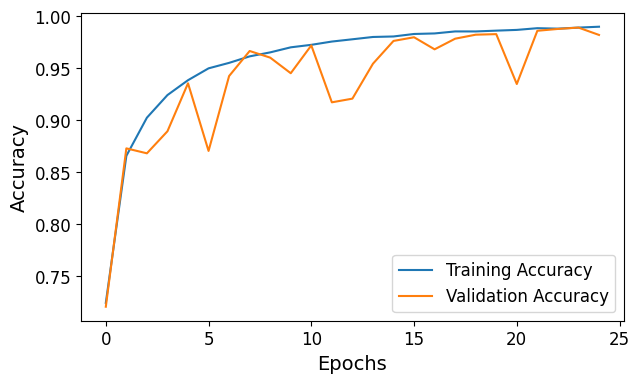

In [ ]:
plt.figure(figsize=(7,4))
sn.lineplot(x=range(25), y=history.history['accuracy'], label='Training Accuracy')
sn.lineplot(x=range(25), y=history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

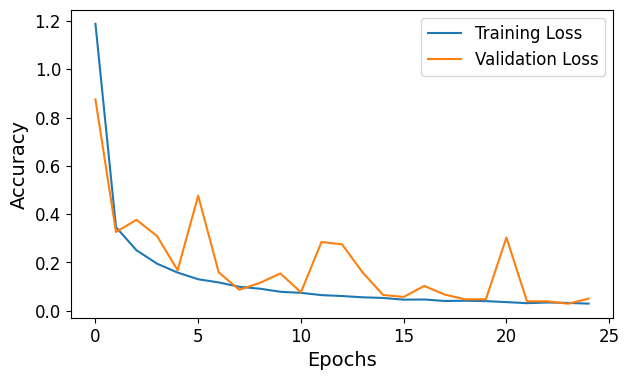

In [11]:
plt.figure(figsize=(7,4))
sn.lineplot(x=range(25), y=history.history['loss'], label='Training Loss')
sn.lineplot(x=range(25), y=history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

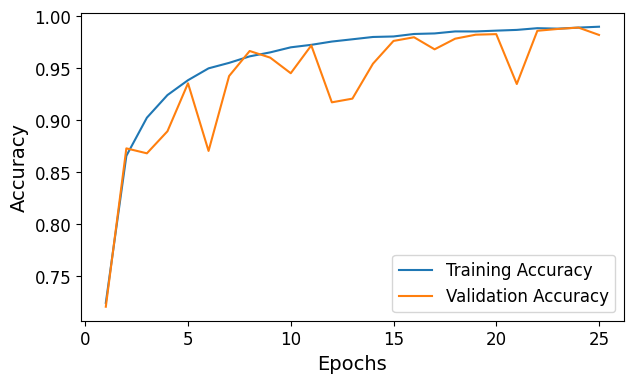

In [23]:
plt.figure(figsize=(7,4))
sn.lineplot(x=range(1,26), y=history.history['accuracy'], label='Training Accuracy')
sn.lineplot(x=range(1,26), y=history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

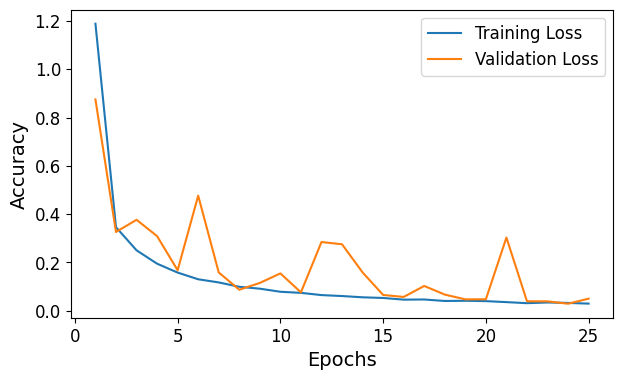

In [24]:
plt.figure(figsize=(7,4))
sn.lineplot(x=range(1,26), y=history.history['loss'], label='Training Loss')
sn.lineplot(x=range(1,26), y=history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [25]:
model = keras.models.load_model('incep-res__25epochs__21apr2025.h5')

In [26]:
test_ds = keras.utils.image_dataset_from_directory(
    test_path,
    batch_size=32,
    image_size=(72,72),
    shuffle=False
)

Found 13000 files belonging to 26 classes.


In [27]:
model.evaluate(test_ds)

407/407 [==============================] - 33s 80ms/step - loss: 0.0290 - accuracy: 0.9887


[0.028958357870578766, 0.9886922836303711]

In [28]:
lab = np.asarray([], dtype=int)
pred = np.asarray([], dtype=int)
for i, l in test_ds:
    lab = np.concatenate((lab, l), axis=-1)
    pred = np.concatenate((pred, np.argmax(model.predict(i), axis=-1)))
lab

1/1 [==============================] - 0s 186ms/step


array([ 0,  0,  0, ..., 25, 25, 25])

In [29]:
pred.shape

(13000,)

In [30]:
cm = np.zeros((26,26), dtype=int)
for i in range(len(pred)):
    cm[pred[i]][lab[i]] += 1

In [31]:
cm

array([[500,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 497,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 500,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 500,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 499,  28,   2,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 461,   9,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   1,  11, 489,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   

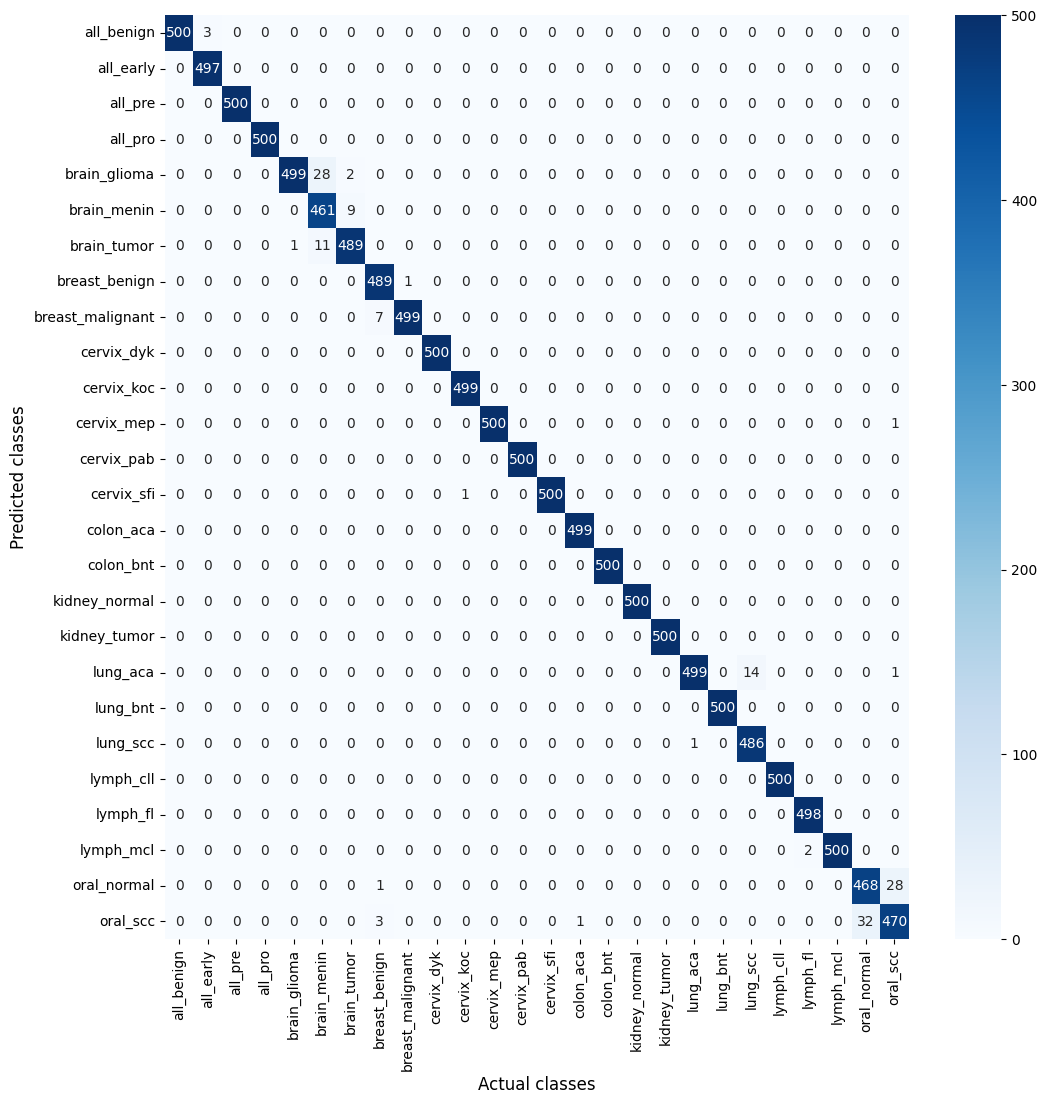

In [32]:
plt.figure(figsize=(12, 12))
# sn.heatmap(cm, cmap='Blues', xticklabels=test_ds.class_names, yticklabels=test_ds.class_names, annot=True, fmt='d', linewidths=0.1, linecolor='white')
sn.heatmap(cm, cmap='Blues', xticklabels=test_ds.class_names, yticklabels=test_ds.class_names, annot=True, fmt='d')
plt.xlabel('Actual classes',fontsize=12)
plt.ylabel('Predicted classes',fontsize=12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
plt.show()

In [33]:
dt = {
    'ALL': [0,1,2,3],
    'Brain': [4,5,6],
    'Breast': [7,8],
    'Cervical': [9,10,11,12,13],
    'Kidney': [14,15],
    'Lung and Colon': [16,17,18,19,20],
    'Lymphoma': [21,22,23],
    'Oral': [24,25]
}

In [34]:
cm_8x8 = np.zeros((8, 8), dtype=int)
group_to_index = {}
current_index = 0
for group_name, indices in dt.items():
    group_to_index[group_name] = current_index
    current_index += 1

def find_group_by_index(index):
    for group_name, indices in dt.items():
        if index in indices:
            return group_name
    return None
for i in range(56):
    for j in range(56):
        group_i = find_group_by_index(i)
        group_j = find_group_by_index(j)
        if group_i is not None and group_j is not None:
            new_i = group_to_index[group_i]
            new_j = group_to_index[group_j]
            cm_8x8[new_i, new_j] += cm[i, j]

#Final soln
print(cm_8x8)

[[2000    0    0    0    0    0    0    0]
 [   0 1500    0    0    0    0    0    0]
 [   0    0  996    0    0    0    0    0]
 [   0    0    0 2500    0    0    0    1]
 [   0    0    0    0  999    0    0    0]
 [   0    0    0    0    0 2500    0    1]
 [   0    0    0    0    0    0 1500    0]
 [   0    0    4    0    1    0    0  998]]


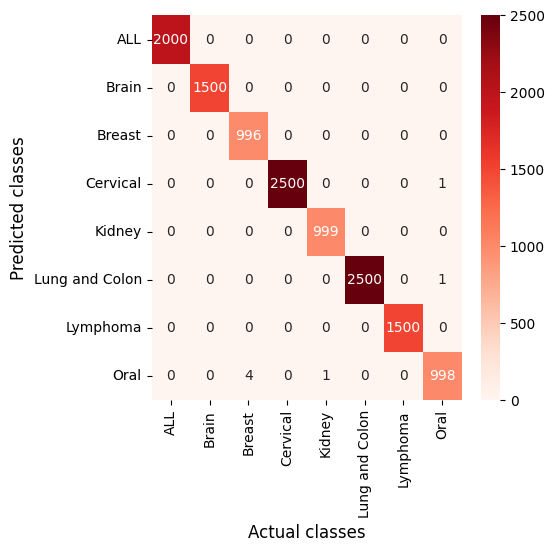

In [35]:
plt.figure(figsize=(5, 5))
# sn.heatmap(cm, cmap='Blues', xticklabels=test_ds.class_names, yticklabels=test_ds.class_names, annot=True, fmt='d', linewidths=0.1, linecolor='white')
sn.heatmap(cm_8x8, cmap='Reds', xticklabels=dt.keys(), yticklabels=dt.keys(), annot=True, fmt='d')
plt.xlabel('Actual classes',fontsize=12)
plt.ylabel('Predicted classes',fontsize=12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
plt.show()

In [36]:
prec = np.zeros(26)
rec = np.zeros(26)

for i in range(26):
    prec[i] = cm[i][i]/sum(cm[i])
    rec[i] = cm[i][i]/sum(cm)[i]

f1 = np.asarray([2*prec[i]*rec[i]/(prec[i]+rec[i]) for i in range(26)])

precision = sum(prec)/26
recall = sum(rec)/26
f1_score = sum(f1)/26


precision, recall, f1_score

(0.9888323260383557, 0.9886923076923076, 0.9886758445659781)